# DEEP FAKE TASK 2: Based on compressed spectrum features [reference](https://github.com/search?l=Jupyter+Notebook&q=deepfake&type=Repositories )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pandas as pd
from scipy import stats
import glob
import pickle
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import dlib

from google.colab import drive
from skimage.morphology import convex_hull_image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.neural_network import MLPClassifier
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    return radial_prof

Reference :

(Paper: https://arxiv.org/abs/1911.00686).

(Repo https://github.com/cc-hpc-itwm/DeepFakeDetection )


In [ ]:
# original code

In [ ]:
def load_facedetector():
    """Loads dlib face and landmark detector."""
    # download if missing http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    root_dir = "/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/Face warp artifacts experiment/dlib_model"
    if not os.path.isfile(root_dir+'/shape_predictor_68_face_landmarks.dat'):
        print ('Could not find shape_predictor_68_face_landmarks.dat.')
        exit(-1)
    face_detector = dlib.get_frontal_face_detector()
    sp68 = dlib.shape_predictor(root_dir+'/shape_predictor_68_face_landmarks.dat')

    return face_detector, sp68

face_detector, sp68 = load_facedetector()

In [ ]:
def shape_to_np(shape):
    number_of_points = shape.num_parts
    points = np.zeros((number_of_points, 2), dtype=np.int32)
    for i in range(0, number_of_points):
        points[i] = (shape.part(i).x, shape.part(i).y)

    return points
def get_crops_landmarks(facedetector, sp68, img, roi_delta=0.0, min_score=0.0):
    """Detects faces and landmarks in image, crops image to face region."""
    face_crops = []
    final_landmarks = []

    dets, scores, idx = facedetector.run(img, 0, 0)

    num_faces = len(dets)
    if num_faces == 0:
        return face_crops, final_landmarks

    # extract especially frontal faces
    if min_score > 0.0:
        dets_new = []
        for i in range(len(dets)):
            if scores[i] > min_score:
                dets_new.append(dets[i])
        dets = dets_new

    # detect landmarks and transform to np array
    landmarks = []
    for detection in dets:
        sp_result = sp68(img, detection)
        landmarks.append(shape_to_np(sp_result))

    # crop faces
    for num in range(len(dets)):
        # copy landmarks and get crop
        face_roi = dets[num]
        face_roi = dlib.rectangle(max(0, face_roi.left()), max(0, face_roi.top()), max(0, face_roi.right()),
                                 max(0, face_roi.bottom()))

        # extend face ROI if needed
        delta_percent = roi_delta
        height = face_roi.bottom() - face_roi.top()
        delta = int(delta_percent * height)
        extended_roi_top = np.clip(face_roi.top() - delta, 0, img.shape[0])
        extended_roi_bottom = np.clip(face_roi.bottom() + delta, 0, img.shape[0])
        extended_roi_left = np.clip(face_roi.left() - delta, 0, img.shape[1])
        extended_roi_right = np.clip(face_roi.right() + delta, 0, img.shape[1])
        cropped_face = img[extended_roi_top:extended_roi_bottom, extended_roi_left:extended_roi_right, :]

        face_landmarks = landmarks[num].copy()

        face_landmarks[:, 0] = face_landmarks[:, 0] - extended_roi_left
        face_landmarks[:, 1] = face_landmarks[:, 1] - extended_roi_top

        final_landmarks.append(face_landmarks)
        face_crops.append(cropped_face)

    return face_crops, final_landmarks

In [ ]:
% cd /content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/CODE/TASK_1

/content/drive/.shortcut-targets-by-id/1hMajpu3lOFIQtcgOnINnNkd6M7Xf_-Tu/CODE/TASK_1


# Task 2 

In [ ]:

data= {}
epsilon = 1e-8
N = 300
y = []
error = []

number_iter = 300

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)

discard_real = 0
discard_fake = 0

cont = 0

#fake data
rootdir = '/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/data/Task_2_3/evaluation/fake'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:        

        filename = os.path.join(subdir, file)
        
        img2 = cv2.imread(filename,0)
        #print("original: ",img.shape)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        extend_roi = 0.0
        face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img2,
                                                    roi_delta=extend_roi)
        img2 = np.array(face_crops)
        #print(filename)
        if len(img2.shape) < 4:
          #print("no face detected on fake")
          discard_fake = discard_fake +1
          psd1D_total[cont,:] = 0             
          label_total[cont] = 0
          cont = cont+1 
          #print("{}, {}".format(cont,filename))   
        elif len(img2.shape) == 4:
          img = np.squeeze(img2)
          img = img[:,:,0]
          #print("cropped: ",img2.shape)
          h = int(img.shape[0]/3)
          w = int(img.shape[1]/3)
          img = img[h:-h,w:-w]
          f = np.fft.fft2(img)
          fshift = np.fft.fftshift(f)

          magnitude_spectrum = 20*np.log(np.abs(fshift))
          psd1D = azimuthalAverage(magnitude_spectrum)

          # Calculate the azimuthally averaged 1D power spectrum
          points = np.linspace(0,N,num=psd1D.size) # coordinates of a
          xi = np.linspace(0,N,num=N) # coordinates for interpolation

          interpolated = griddata(points,psd1D,xi,method='cubic')
          interpolated /= interpolated[0]

          psd1D_total[cont,:] = interpolated             
          label_total[cont] = 0
          cont+=1
        if cont == number_iter:
            break
    if cont == number_iter:
        break

## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)


cont = 0
rootdir2 = '/content/drive/MyDrive/Colab Notebooks/Deep Fake - PDBR/data/Task_2_3/evaluation/real'
aux = 0

for subdir, dirs, files in os.walk(rootdir2):
    for file in files:  

        filename = os.path.join(subdir, file)
        
        img2 = cv2.imread(filename,0)
        #print("original: ",img.shape)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        extend_roi = 0.0
        face_crops, final_landmarks = get_crops_landmarks(face_detector, sp68, img2,
                                                    roi_delta=extend_roi)
        img2 = np.array(face_crops)
        #print(img2.shape)
        if len(img2.shape) < 4:
          #print("no face detected on real")
          discard_real = discard_real+1
          psd1D_total2[cont,:] = 0             
          label_total2[cont] = 0
          cont = cont+1
          #print("{}, {}".format(cont,filename))
        elif len(img2.shape) == 4:
          img = np.squeeze(img2)
          img = img[:,:,0]
          #print("cropped: ",img2.shape)
          h = int(img.shape[0]/3)
          w = int(img.shape[1]/3)
          img = img[h:-h,w:-w]
          f = np.fft.fft2(img)
          fshift = np.fft.fftshift(f)

          magnitude_spectrum = 20*np.log(np.abs(fshift))
          psd1D = azimuthalAverage(magnitude_spectrum)

          # Calculate the azimuthally averaged 1D power spectrum
          points = np.linspace(0,N,num=psd1D.size) # coordinates of a
          xi = np.linspace(0,N,num=N) # coordinates for interpolation

          interpolated = griddata(points,psd1D,xi,method='cubic')
          interpolated /= interpolated[0]

          psd1D_total2[cont,:] = interpolated             
          label_total2[cont] = 1
          cont+=1
        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])


y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('task2.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 

print('Discarded eval real', discard_real)
print('Discarded eval fake', discard_fake)


DATA Saved
Discarded eval real 7
Discarded eval fake 4


600

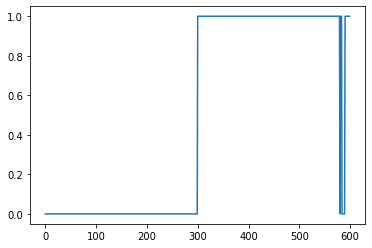

In [ ]:
pkl_file = open('task2.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_task2 = data["data"]
y_task2 = data["label"]

plt.plot(y_task2)
X_task2.shape[0]

In [ ]:
x_task2 = pd.DataFrame(X_task2)
y_task2 = pd.DataFrame(y_task2)
df_Task2 = []
df_Task2 = x_task2
df_Task2['label'] = y_task2


In [ ]:
df_Task2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 301 entries, 0 to label
dtypes: float64(301)
memory usage: 1.4 MB


In [ ]:
#X_training = df_Train.loc[:, df_Train.columns != 'label']

X_task2_  = df_Task2.loc[:, df_Task2.columns != 'label']

svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
svclassifier_r.fit(X_training, df_Train["label"])
y_pred = svclassifier_r.predict(X_task2_)


print("svc acc:  ",accuracy_score(df_Task2["label"], y_pred))
print("(SVC) - AUC: ", roc_auc_score(df_Task2["label"], y_pred))

svc acc:   0.5333333333333333
(SVC) - AUC:  0.542495358584118
